In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrowPatch
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

In [4]:
# Define the file paths
landsat_fp = 'data/landsat8-2018-01-26-sb-simplified.nc'
perimeter_fp=os.path.join('data', 'California_Fire_Perimeters_(all).shp')

# Read the raster data using rioxarray
landsat = rioxr.open_rasterio(landsat_fp)

# Read the shapefile using geopandas
fire_perimeter=gpd.read_file(perimeter_fp)

# Read CSV files
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2017.zip',compression='zip')
aqi_18 = pd.read_csv('data/daily_aqi_by_county_2018.zip',compression='zip')

# Concatenate DataFrames aqi_17 and aqi_18 along the default axis
aqi = pd.concat([aqi_17, aqi_18])

In [272]:
# Print fire_perimeter projection
print(f"{'The CRS of fire_perimeter is:':} {fire_perimeter.crs}")

# Display the first few rows of the DataFrame to get an overview of the data
fire_perimeter.head(3)

The CRS of fire_perimeter is: EPSG:3857


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2023,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17,2023-06-17,5,1,1,5.72913,None,None,{7985848C-0AC2-4BA4-8F0E-29F778652E61},None,None,2020,"POLYGON ((-13682443 5091132.739, -13682445.825..."
1,2023,CA,LRA,BTU,KAISER,00010225,2023-06-02,2023-06-02,5,1,1,13.60240,None,None,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},None,None,2020,"POLYGON ((-13576727.142 4841226.161, -13576726..."
2,2023,CA,CDF,AEU,JACKSON,00017640,2023-07-01,2023-07-02,2,1,1,27.81450,None,None,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},None,None,2020,"POLYGON ((-13459243 4621236, -13458968 4621453..."


In [273]:
# Replace spaces with underscores and convert to lowercase
fire_perimeter.columns = fire_perimeter.columns.str.rstrip().str.replace(' ', '_').str.lower()

# Replace the column name 'year' explicitly to avoid '_'
fire_perimeter.columns = fire_perimeter.columns.str.replace(r'year_', 'year')

In [274]:
# Filter the fire perimeter for the 2017 Thomas Fire
thomas_fire = fire_perimeter[(fire_perimeter['fire_name'] == 'THOMAS') & (fire_perimeter['year'] == 2017)]

In [275]:
# Display the head() of the dataframe to get an overview of the data
landsat.head()

<xarray.Dataset> Size: 1kB
Dimensions:      (x: 5, y: 5, band: 1)
Coordinates:
  * x            (x) float64 40B -1.349e+07 -1.349e+07 ... -1.349e+07 -1.349e+07
  * y            (y) float64 40B 4.26e+06 4.26e+06 4.259e+06 4.259e+06 4.259e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 200B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    green        (band, y, x) float64 200B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    blue         (band, y, x) float64 200B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nir08        (band, y, x) float64 200B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swir22       (band, y, x) float64 200B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [276]:
# Remove length 1 dimension (band)
landsat = landsat.squeeze()

# Remove coordinates associated to band
landsat = landsat.drop('band')

/var/folders/5l/75rl_f0n5xvcqfryr6n357100000gn/T/ipykernel_18755/4025422333.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  landsat = landsat.drop('band')


In [277]:
# Display the head() of the dataframe to get an overview of the data
aqi.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,28,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,29,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,25,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,40,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,22,Good,PM2.5,01-003-0010,1


In [278]:
# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

# Filter to include only the rows where the county name is 'Santa Barbara' & 'Ventura"
aqi_sb = aqi[(aqi['county_name'] == 'Santa Barbara') | (aqi['county_name'] == 'Ventura')]

# Drop unnecessary columns('state_name', 'county_name', 'state_code', and 'county_code')
aqi_sb = aqi_sb.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis=1)

In [279]:
# Check data type of each column
print("Data Types: ", aqi.dtypes)

Data Types:  state_name                   object
county_name                  object
state_code                    int64
county_code                   int64
date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object


In [280]:
# Convert 'date' column in the aqi_sb DataFrame to datetime format
aqi_sb.date = pd.to_datetime(aqi_sb['date'])

# Set the 'date' column as the index and sort by index
aqi_sb = aqi_sb.set_index('date').sort_index()

# Calculate AQI rolling average over 5 days
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()

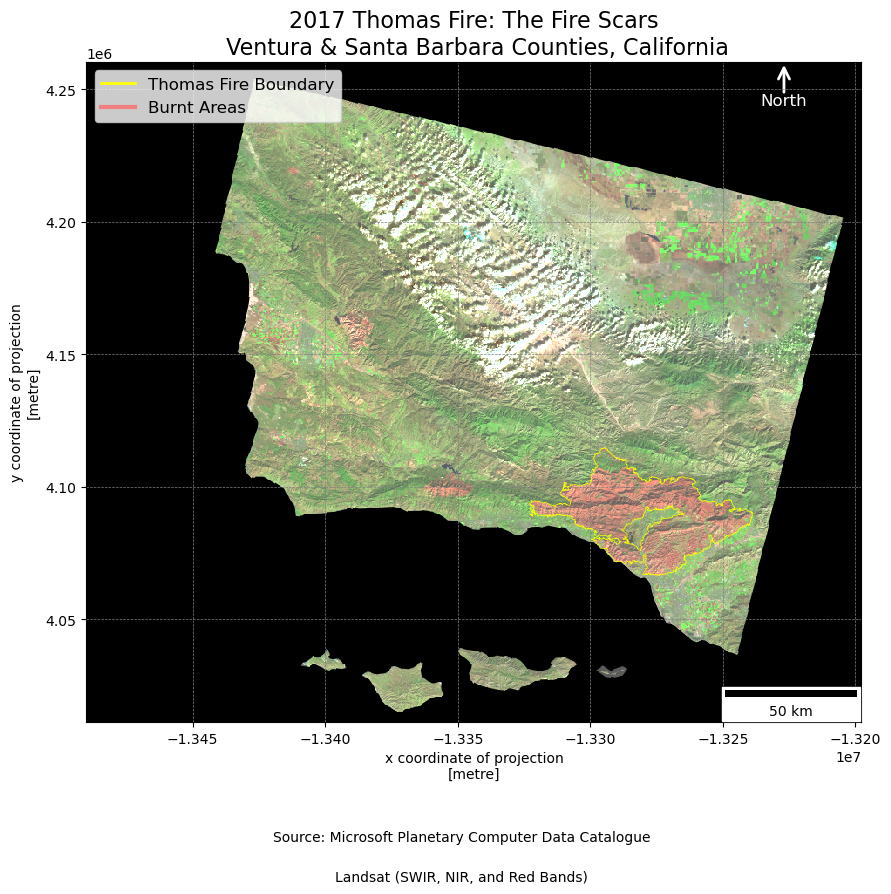

In [281]:
# Create a figure and axis
fig, ax = plt.subplots(figsize = (10, 10))

# Plot the false color image (SWIR, NIR, Red bands)
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, robust=True)

# Plot the Thomas Fire boundary
thomas_fire.boundary.plot(ax = ax, edgecolor='yellow', linewidth=0.5, label="Thomas Fire Boundary")

# Add title
ax.set_title("2017 Thomas Fire: The Fire Scars\n Ventura & Santa Barbara Counties, California", fontsize=16)

# Create custom legend entries for both boundary and burnt areas
legend_elements = [
    Line2D([0], [0], color='yellow', lw=2, label='Thomas Fire Boundary'), 
    Line2D([0], [0], color='lightcoral', lw=3, label='Burnt Areas') 
]
# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Add a Scale Bar
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)

# Add North Arrow
arrow = FancyArrowPatch(
    (0.9, 0.95), (0.9, 1), 
    mutation_scale=20, 
    color='white', 
    lw=2, 
    arrowstyle='->', 
    label='North', 
    transform=ax.transAxes
)
ax.add_patch(arrow)

# Add a label for "North"
ax.text(0.9, 0.93, 'North', color='white', fontsize=12, ha='center', va='bottom', transform=ax.transAxes)

# Add grids
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Add captions
fig.text(0.5, 0.05, 'Source: Microsoft Planetary Computer Data Catalogue', ha='center', va='center', fontsize=10, color='black')
fig.text(0.5, 0.01, 'Landsat (SWIR, NIR, and Red Bands)', ha='center', va='center', fontsize=10, color='black')

# Display the map
plt.show()

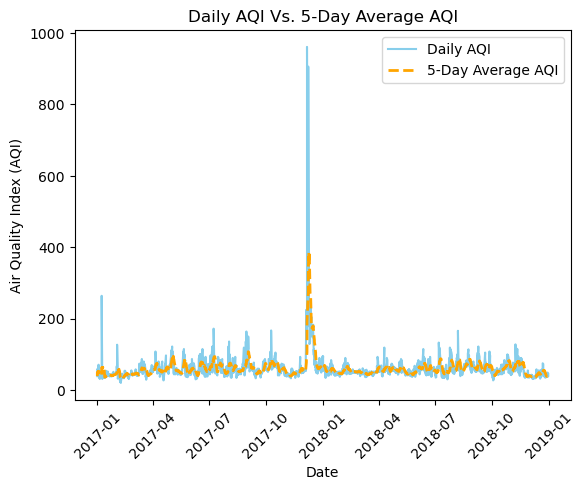

In [304]:
# Plot the daily AQI
plt.plot(aqi_sb.index, aqi_sb['aqi'], label='Daily AQI', color='skyblue', linestyle='-')

# Plot the 5-day average AQI
plt.plot(aqi_sb.index, aqi_sb['five_day_average'], label='5-Day Average AQI', color='orange', linestyle='--', linewidth=2)


# Add titles, labels and legend
plt.title('Daily AQI Vs. 5-Day Average AQI')
plt.xlabel('Date')
plt.ylabel('Air Quality Index (AQI)')
plt.legend()

# Rotate x-labels at a 45 angle in order to fit in graph
plt.xticks(rotation=45)

# Show plot
plt.show()